# Packages

In [1]:
import os
import time
import umap
import numpy as np
import scanpy as sc
import pandas as pd
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import gaussian_kde

# Diffusion matrix

In [2]:
%reload_ext memory_profiler

In [3]:
%%memit
diffusion_adata=sc.read_h5ad('/mnt/thechenlab/Mehdi/recon_umaps_c58_H4/H4_2_rec_merge/H4_2_rec_merge_filtered_.05p_log1p.h5ad')
diffusion_filtered = diffusion_adata[diffusion_adata.obs['n_counts'] > 0, diffusion_adata.var['n_counts'] > 0]
counts = diffusion_filtered.X

peak memory: 1950.94 MiB, increment: 1240.10 MiB


In [4]:
counts

<878211x207289 sparse matrix of type '<class 'numpy.float32'>'
	with 47419940 stored elements in Compressed Sparse Row format>

# Reconstruction with UMAP

In [ ]:
%%memit
n_epo = 10000

time5 = time.time()
reducer = umap.UMAP(metric='cosine',
                    n_neighbors=45, 
                    min_dist=0.4, 
                    low_memory=False, 
                    n_components=2, 
                    # random_state=0, 
                    verbose=True, 
                    n_epochs=n_epo,
                    # output_dens = True,
                    # local_connectivity = 30,
                    learning_rate = 1)
embedding = reducer.fit_transform(counts)
time_loop = time.time()
print('umap: ', time_loop-time5)

# Slide-seq data stats

## For reviewer: UEI per bead

In [ ]:
diffusion_filtered = sc.read_h5ad('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Data_Figures/Slide_recon_P1/H4_2_rec_merge_filtered_.05p_log1p.h5ad')

In [40]:
adata = sc.read_h5ad('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Data_Figures/Slide_recon_P1/adata_GeneFull_raw_matrix.h5ad')

In [41]:
a_df = pd.merge(adata.obs[['x','y']].copy(), diffusion_filtered.obs, left_index=True, right_index=True)

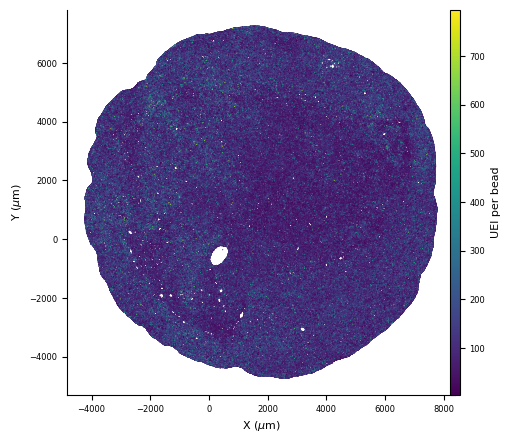

In [94]:
## FigS4k
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
im = ax.scatter(x=a_df.x, y=-a_df.y, c=a_df.n_counts, alpha=1, s=0.6, edgecolor='none',cmap='viridis')
plt.axis('equal')
plt.xlabel('X ($\mu$m)', fontsize=8)
plt.ylabel('Y ($\mu$m)', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
cax = fig.add_axes([ax.get_position().x1-0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=6, which='major') 
cbar.set_label('UEI per bead', fontsize=8)
# plt.subplots_adjust(left=0.1, right=0.8, top=0.8, bottom=0.1)
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4k_H4_2_uei_per_bead_spatial.png'),dpi=300)
plt.show()

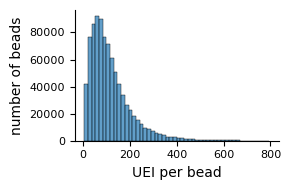

In [47]:
plt.figure(figsize=(3, 2))
sns.histplot(a_df.n_counts, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('UEI per bead', fontsize=10)
plt.ylabel('number of beads', fontsize=10)
# plt.grid(True, linestyle='--', alpha=0.7)

plt.tick_params(axis='both', which='major', labelsize=8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4m_H4_2_uei_per_bead_hist.png'),dpi=300)
plt.show()

## For reviewer: before segmentation

In [34]:
adata = sc.read_h5ad('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Data_Figures/Slide_recon_P1/adata_GeneFull_raw_matrix.h5ad')

In [35]:
adata.obs['n_genes'] = adata.obs['n_genes'].replace([np.inf, -np.inf], np.nan)

# Then, remove rows where 'n_genes' is NaN
adata = adata[~adata.obs['n_genes'].isna()]

# Then, remove rows where 'n_genes' is NaN
adata = adata[~adata.obs['x'].isna()]

In [36]:
x = adata.obs.x.values
y = adata.obs.y.values
xmin, xmax = min(x), max(x)
ymin, ymax = min(y), max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values, weights=adata.obs.n_genes.values)
f = np.reshape(kernel(positions).T, xx.shape)

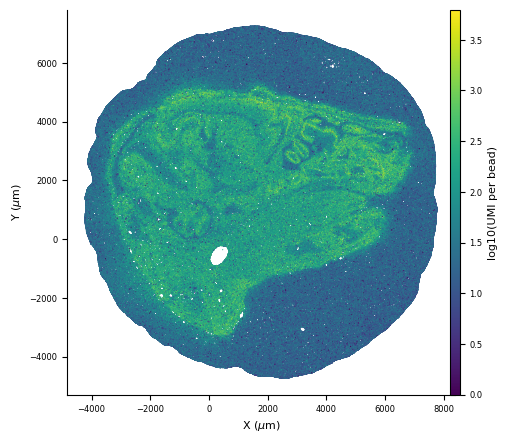

In [95]:
## FigS4l
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
im = ax.scatter(x=adata.obs.x, y=-adata.obs.y, c=adata.obs.log10_counts, alpha=1, s=0.6, edgecolor='none',cmap='viridis')
plt.axis('equal')
plt.xlabel('X ($\mu$m)', fontsize=8)
plt.ylabel('Y ($\mu$m)', fontsize=8)
plt.tick_params(axis='both', which='major', labelsize=6)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
cax = fig.add_axes([ax.get_position().x1-0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=6, which='major') 
cbar.set_label('log10(UMI per bead)', fontsize=8)
# cset = ax.contour(xx, -yy, f, colors='k',levels=[6.0e-09])
# plt.tight_layout()
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4l_H4_2_umi_per_bead_spatial_whole.png'),dpi=300)
# plt.close()
plt.show()

## FigS9_a

gene expression library were analyzed by Slide-seq pipeline and RCTD

In [2]:
adata = sc.read_h5ad('/mnt/thechenlab/Chenlei/spotmapping/fiducial/data/H4_2/H4_2_mask_RCTD_result.h5ad')

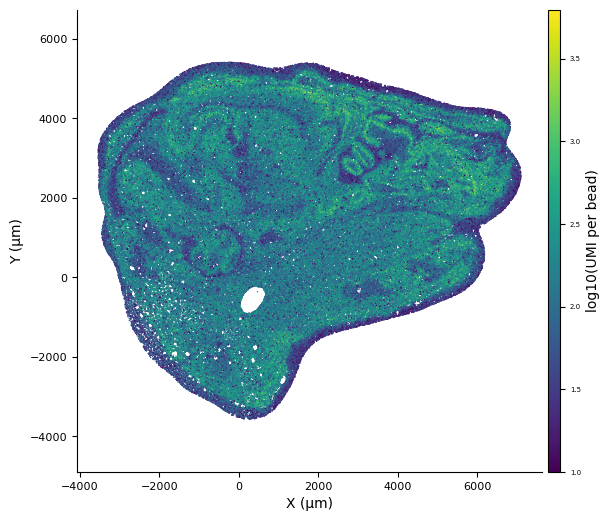

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
im = ax.scatter(x=adata.obs.x, y=adata.obs.y, c=adata.obs.log10_counts, alpha=1, s=1, edgecolor='none',cmap='viridis')
plt.axis('equal')
plt.xlabel('X (µm)', fontsize=10)
plt.ylabel('Y (µm)', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=5, which='major') 
cbar.set_label('log10(UMI per bead)', fontsize=10)
# plt.tight_layout()
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4a_H4_2_umi_per_bead_spatial.png'),dpi=300)
# plt.close()
plt.show()

## FigS9_b

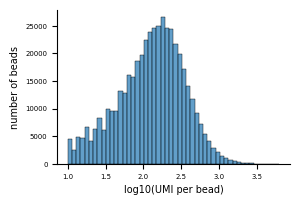

In [109]:
plt.figure(figsize=(3, 2))
sns.histplot(adata.obs.log10_counts, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('log10(UMI per bead)', fontsize=7)
plt.ylabel('number of beads', fontsize=7)
# plt.grid(True, linestyle='--', alpha=0.7)

plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4b_H4_2_umi_per_bead_hist.svg'),dpi=300)
plt.show()

## FigS9_c

In [2]:
palette = sns.color_palette(['#0d0305','#3c3444','#6e576e','#917d9b','#c5b7cb','#5f4f47','#851246','#d72048','#7d322f',
                             '#9d4c2f','#c65e2d','#f96a2d','#ffa300','#e29138','#f7c233','#11442c','#287a33','#52b139',
                             '#8ae931','#203c62','#2a69b0','#00a1de','#6bdad5','#a52eb8','#f7406e','#fc83a2','#f9cf9d','#fba176','#f66f67',])

In [19]:
type_order = ['Dermatome','Early chondrocytes','Definitive_erythroid','Adipocytes','Eye_and_other',
              'B_cells','Megakaryocytes','Olfactory_sensory_neurons','Fibroblasts','Facial mesenchyme','T_cells',
              'Chondrocytes (Otor+)','Ependymal_cells','Endothelium', 'Neuroectoderm_and_glia',
             'Intermediate_neuronal_progenitors','CNS_neurons','Epithelial_cells','Lateral plate and intermediate mesoderm',
             'Mast_cells','Neural_crest_PNS_glia','Neural_crest_PNS_neurons','Oligodendrocytes',
             'Lung_and_airway','Pre-osteoblasts (Sp7+)','Sclerotome','White_blood_cells','Muscle_cells','Chondrocytes (Atp1a2+)']

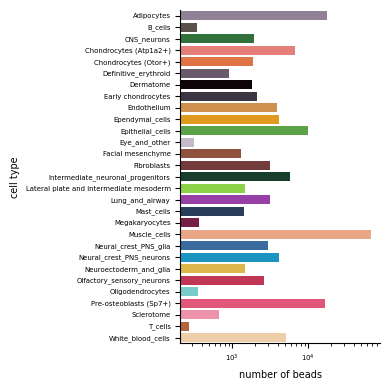

In [28]:
## FigS4c
fig = plt.figure(figsize=(4, 4))
sns.barplot(pd.DataFrame({'counts': Counter(adata.obs[adata.obs['spot_class'] == 'singlet']['first_type'])}).reset_index().rename(columns={'index': 'first_type'}),
           y='first_type',x='counts',hue='first_type', palette=palette, hue_order=type_order)
plt.xlabel('number of beads', fontsize=7)
plt.ylabel('cell type', fontsize=7)
plt.xscale('log')
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4c_H4_2_cell_type_bar.png'),dpi=300, bbox_inches='tight')
# plt.close()
plt.show()

# Slide-seq of P1 with reconstruction results

## Fig2_f

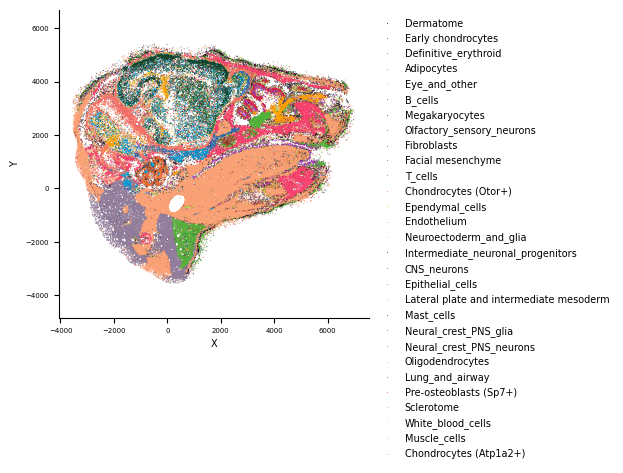

In [182]:
plt.figure(figsize=(4, 4))
sns.scatterplot(adata.obs[adata.obs.spot_class != 'singlet'], x="x", y="y", color='#E3E3E3', s=0.1, edgecolor=None)
sns.scatterplot(adata.obs[adata.obs.spot_class == 'singlet'], x="x", y="y", hue="first_type", s=0.4, edgecolor=None, palette=palette, hue_order=type_order)

plt.axis('equal')
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.xlabel('X', fontsize=7)
plt.ylabel('Y', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4','Fig4a_H4_2_cell_type_spatial.svg'),
#             dpi=300, bbox_inches='tight')
plt.show()

## Fig2_g

In [19]:
bead_umap = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs.index, columns=['UMAP1','UMAP2'])
bead_umap = bead_umap.merge(adata.obs[['spot_class','first_type']], left_index=True, right_index=True)

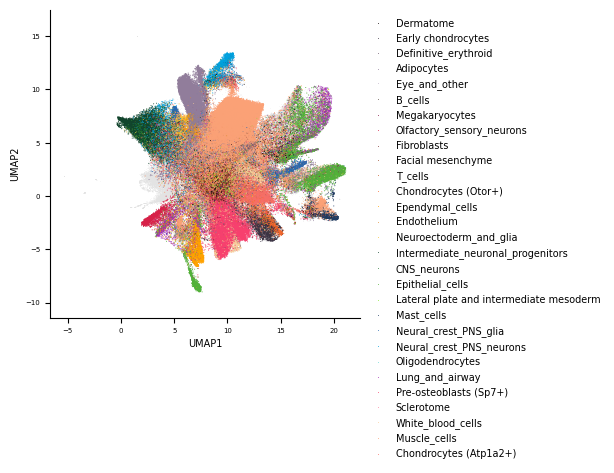

In [126]:
plt.figure(figsize=(4, 4))

sns.scatterplot(bead_umap[bead_umap.spot_class != 'singlet'], x="UMAP1", y="UMAP2", color='#E3E3E3', s=0.1, edgecolor=None)
sns.scatterplot(bead_umap[bead_umap.spot_class == 'singlet'], x="UMAP1", y="UMAP2", hue="first_type", s=0.4, edgecolor=None, palette=palette, hue_order=type_order)

plt.axis('equal')
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.xlabel('UMAP1', fontsize=7)
plt.ylabel('UMAP2', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4','Fig4b_H4_2_cell_type_umap.png'),
#             dpi=300, bbox_inches='tight')
plt.show()

# Cell types

## FigS10

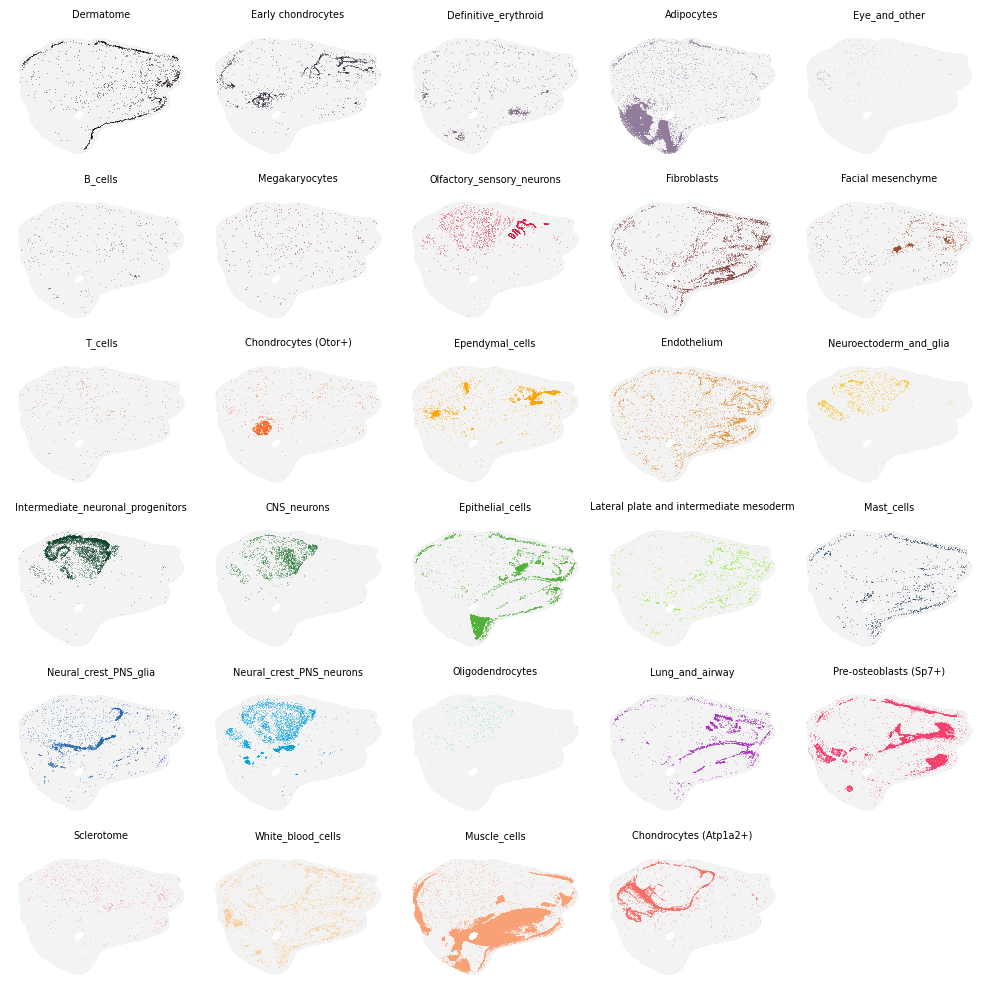

In [155]:
fig, axs = plt.subplots(6, 5, figsize=(10, 10))

for i, ax in enumerate(axs.flat):
    if i < 29:
        ct = type_order[i]
        sns.scatterplot(adata.obs[(adata.obs.spot_class != 'singlet') | (adata.obs.first_type!=ct)]
                        , x="x", y="y", color='#F3F3F3', s=0.1, edgecolor=None, ax=ax)
        sns.scatterplot(adata.obs[(adata.obs.spot_class=='singlet') & (adata.obs.first_type==ct)]
                             , x="x", y="y", color=palette[i], s=0.2, edgecolor=None, ax=ax, legend=False)
        plt.axis('equal')
        ax.set_title(ct, fontsize=7, pad=10)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
fig.delaxes(axs[5][4])
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4d_H4_2_cell_type_single.png'),dpi=300)
plt.tight_layout()
plt.show()

# Cell types and marker genes

In [ ]:
sc.tl.rank_genes_groups(adata, groupby='first_type', method='wilcoxon', n_jobs=20)
cluster_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']) 

## Fig2_h

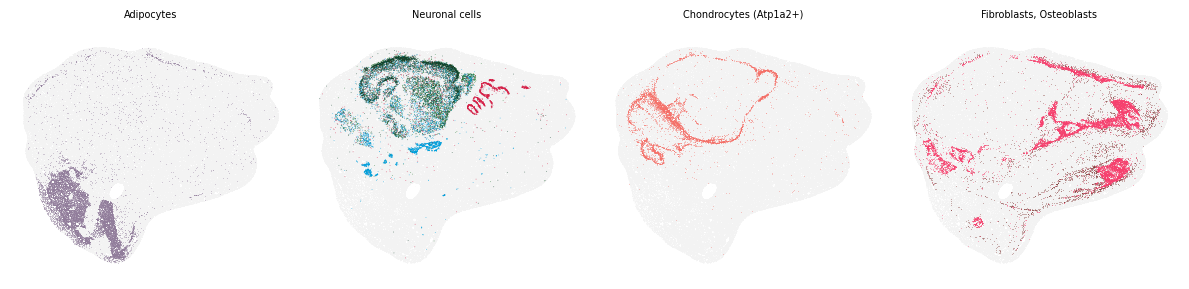

In [127]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

sns.scatterplot(adata.obs[(adata.obs.spot_class != 'singlet') | (adata.obs.first_type!='Adipocytes')]
                , x="x", y="y", color='#F3F3F3', s=0.1, edgecolor=None, ax=axs[0])
sns.scatterplot(adata.obs[(adata.obs.spot_class=='singlet') & (adata.obs.first_type=='Adipocytes')]
                     , x="x", y="y", color=palette[type_order.index('Adipocytes')], s=0.2, edgecolor=None, ax=axs[0], legend=False)
axs[0].axis('equal')
axs[0].set_title('Adipocytes', fontsize=7, pad=10)
axs[0].spines['top'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].spines['left'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('')
axs[0].set_ylabel('')

neuronal_types = ['CNS_neurons','Neural_crest_PNS_neurons','Olfactory_sensory_neurons','Intermediate_neuronal_progenitors']
neuronal_palette = [palette[type_order.index(i)] for i in neuronal_types]
sns.scatterplot(adata.obs[(adata.obs.spot_class != 'singlet') | (~adata.obs['first_type'].isin(neuronal_types))]
                , x="x", y="y", color='#F3F3F3', s=0.1, edgecolor=None, ax=axs[1])
sns.scatterplot(adata.obs[(adata.obs.spot_class=='singlet') & (adata.obs.first_type.isin(neuronal_types))]
                     , x="x", y="y", palette=neuronal_palette,hue_order=neuronal_types, hue='first_type',
                s=0.2, edgecolor=None, ax=axs[1], legend=False)
axs[1].axis('equal')
axs[1].set_title('Neuronal cells', fontsize=7, pad=10)
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_xlabel('')
axs[1].set_ylabel('')

sns.scatterplot(adata.obs[(adata.obs.spot_class != 'singlet') | (adata.obs.first_type!='Chondrocytes (Atp1a2+)')]
                , x="x", y="y", color='#F3F3F3', s=0.1, edgecolor=None, ax=axs[2])
sns.scatterplot(adata.obs[(adata.obs.spot_class=='singlet') & (adata.obs.first_type=='Chondrocytes (Atp1a2+)')]
                     , x="x", y="y", color=palette[type_order.index('Chondrocytes (Atp1a2+)')], s=0.2, edgecolor=None, ax=axs[2], legend=False)
axs[2].axis('equal')
axs[2].set_title('Chondrocytes (Atp1a2+)', fontsize=7, pad=10)
axs[2].spines['top'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)
axs[2].spines['left'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_xlabel('')
axs[2].set_ylabel('')

sns.scatterplot(adata.obs[(adata.obs.spot_class != 'singlet') | (~adata.obs['first_type'].isin(['Pre-osteoblasts (Sp7+)','Fibroblasts']))]
                , x="x", y="y", color='#F3F3F3', s=0.1, edgecolor=None, ax=axs[3])
sns.scatterplot(adata.obs[(adata.obs.spot_class=='singlet') & (adata.obs.first_type=='Fibroblasts')]
                     , x="x", y="y", color=palette[type_order.index('Fibroblasts')], s=0.2, edgecolor=None, ax=axs[3], legend=False)
sns.scatterplot(adata.obs[(adata.obs.spot_class=='singlet') & (adata.obs.first_type=='Pre-osteoblasts (Sp7+)')]
                     , x="x", y="y", color=palette[type_order.index('Pre-osteoblasts (Sp7+)')], s=0.2, edgecolor=None, ax=axs[3], legend=False)

axs[3].axis('equal')
axs[3].set_title('Fibroblasts, Osteoblasts', fontsize=7, pad=10)
axs[3].spines['top'].set_visible(False)
axs[3].spines['bottom'].set_visible(False)
axs[3].spines['left'].set_visible(False)
axs[3].spines['right'].set_visible(False)
axs[3].set_xticks([])
axs[3].set_yticks([])
axs[3].set_xlabel('')
axs[3].set_ylabel('')
        
plt.tight_layout()     
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4','Fig4c_H4_2_cell_type_single4.png'),dpi=300)
plt.show()

## Fig2_i

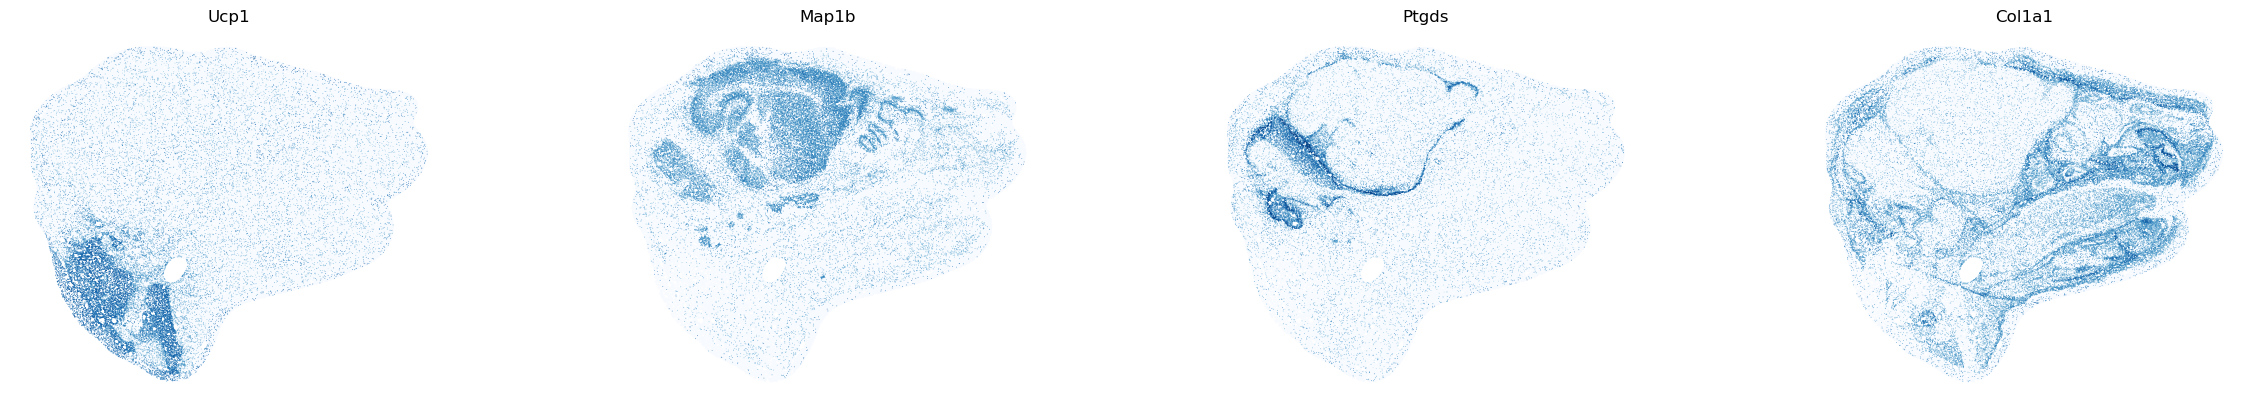

<Figure size 1200x300 with 0 Axes>

In [185]:
## Fig4d
marker_gene4 = ['Ucp1','Map1b','Ptgds','Col1a1']
# sc.settings.figdir = '/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4'
sc.pl.spatial(adata, color=marker_gene4, spot_size=20,
              cmap='Blues',size=1,frameon=False, colorbar_loc=None)#, save='Fig4d_maker_gene4.png')
plt.gcf().set_size_inches(12, 3)  # Set the figure size as width=10, height=8 inches
plt.show()

# Neuronal cells

In [10]:
neuronal_types = ['CNS_neurons','Neural_crest_PNS_neurons','Olfactory_sensory_neurons','Intermediate_neuronal_progenitors']
adata_neuronal = adata[(adata.obs.spot_class == 'singlet') & (adata.obs.first_type.isin(neuronal_types))].copy()

## FigS9_d

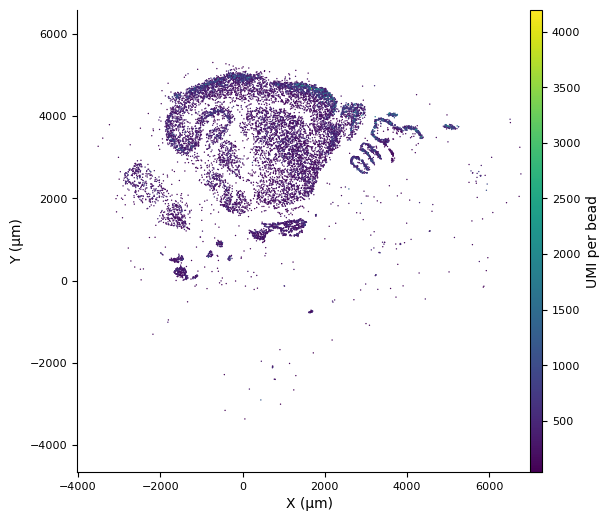

In [14]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
im = ax.scatter(x=adata_neuronal.obs.x, y=adata_neuronal.obs.y, c=adata_neuronal.obs.n_counts
                     , alpha=1, s=1, edgecolor='none',cmap='viridis')
plt.axis('equal')
plt.xlabel('X (µm)', fontsize=10)
plt.ylabel('Y (µm)', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
cax = fig.add_axes([ax.get_position().x1-0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=8, which='major') 
cbar.set_label('UMI per bead', fontsize=10)
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4e_H4_2_umi_per_bead_spatial_neuronal.png'),dpi=300)
# plt.close()
plt.show()

## Fig2_j

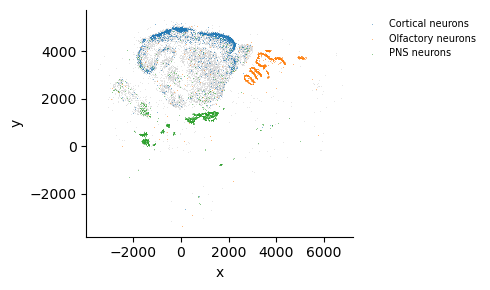

In [41]:
fig, axs = plt.subplots(figsize=(5, 3))

clu_neuronal = ['2','3','5']
clu_label = ['Cortical neurons','Olfactory neurons','PNS neurons']
sns.scatterplot(adata_neuronal.obs[~adata_neuronal.obs.leiden.isin(clu_neuronal)], x="x", y="y", color='#D3D3D3', s=0.3, edgecolor=None)

for i in range(3):
    clu = clu_neuronal[i]
    sns.scatterplot(adata_neuronal.obs[(adata_neuronal.obs.leiden==clu)], x="x", y="y"
                    , color=adata_neuronal.uns['leiden_colors'][i], s=0.3, edgecolor=None, legend=False, label=clu_label[i])
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.axis('equal')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4','Fig4e_H4_2_neuronal_spatial.svg'),dpi=300)
plt.show()

## Fig2_k

/tmp/ipykernel_7663/1225430776.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


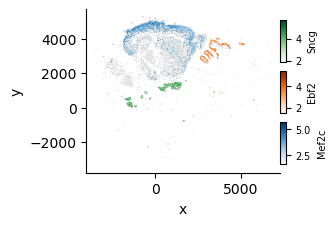

In [187]:
fig, ax = plt.subplots(figsize=(3, 3))
neuronal_marker_gene = ['Mef2c', 'Ebf2', 'Sncg']
neuronal_palette = ['Blues', 'Oranges', 'Greens']

# Base layer scatter plot
sns.scatterplot(ax=ax, data=adata_neuronal.obs, x="x", y="y", color='#E3E3E3', s=0.4, edgecolor=None)

# Create a color bar for each gene
for i, ge in enumerate(neuronal_marker_gene):
    nonzero_bead = np.where(adata_neuronal.raw[:, ge].X.toarray().flatten() > 0)[0]
    # Extract the gene expression values
    ge_values = adata_neuronal.raw[:, ge].X.toarray().flatten()[nonzero_bead]
    # Create a scatter plot for each gene
    points = ax.scatter(adata_neuronal.obs.iloc[nonzero_bead]['x'], adata_neuronal.obs.iloc[nonzero_bead]['y'], 
                        c=ge_values, cmap=neuronal_palette[i], s=0.3, edgecolor='none', label=ge)
    
    # Create an axis for the color bar
    cax = fig.add_axes([0.95, 0.3+0.17*i, 0.02, 0.14])  # Adjust these values to position your color bar
    cbar = plt.colorbar(points, cax=cax, orientation='vertical')
    cbar.set_label(ge, fontsize=7)  # Set the label's fontsize
    cbar.ax.tick_params(labelsize=7)  # Set the tick's fontsize

ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4','Fig4g_H4_2_neuronal_gene_spatial.svg'),dpi=300, bbox_inches='tight')
plt.show()

## FigS9_e

In [34]:
bead_umap_neuronal = pd.DataFrame(adata_neuronal.obsm['X_umap'], index=adata_neuronal.obs.index, columns=['UMAP1','UMAP2'])
bead_umap_neuronal = bead_umap_neuronal.merge(adata_neuronal.obs['leiden'], left_index=True, right_index=True)

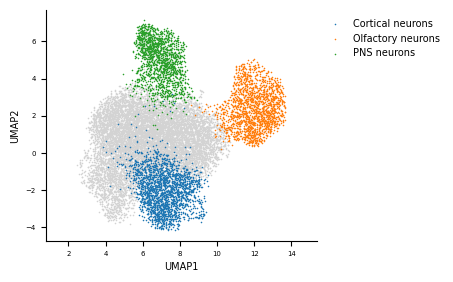

In [40]:
plt.figure(figsize=(3.5, 3))

sns.scatterplot(bead_umap_neuronal[~bead_umap_neuronal.leiden.isin(clu_neuronal)], x="UMAP1", y="UMAP2", color='#D3D3D3', s=1, edgecolor=None)
for i in range(3):
    clu = clu_neuronal[i]
    sns.scatterplot(bead_umap_neuronal[bead_umap_neuronal.leiden==clu], x="UMAP1", y="UMAP2"
                    , color=adata_neuronal.uns['leiden_colors'][i], s=1, edgecolor=None, legend=False, label=clu_label[i])

plt.axis('equal')
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1), fontsize=7)
plt.xlabel('UMAP1', fontsize=7)
plt.ylabel('UMAP2', fontsize=7)
plt.tick_params(axis='both', which='major', labelsize=5)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4','Fig4f_H4_2_neuronal_umap.svg'),dpi=300, bbox_inches='tight')
plt.show()

## FigS9_f

/tmp/ipykernel_7663/931630624.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


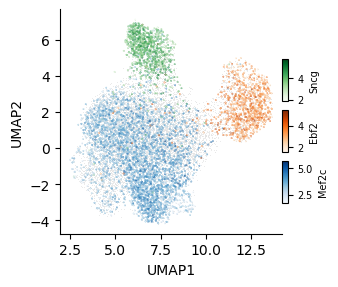

In [196]:
fig, ax = plt.subplots(figsize=(3, 3))
neuronal_marker_gene = ['Mef2c', 'Ebf2', 'Sncg']
neuronal_palette = ['Blues', 'Oranges', 'Greens']

# Base layer scatter plot
sns.scatterplot(ax=ax, data=bead_umap_neuronal, x="UMAP1", y="UMAP2", color='#E3E3E3', s=0.4, edgecolor=None)

# Create a color bar for each gene
for i, ge in enumerate(neuronal_marker_gene):
    nonzero_bead = np.where(adata_neuronal.raw[:, ge].X.toarray().flatten() > 0)[0]
    # Extract the gene expression values
    ge_values = adata_neuronal.raw[:, ge].X.toarray().flatten()[nonzero_bead]
    # Create a scatter plot for each gene
    points = ax.scatter(bead_umap_neuronal.iloc[nonzero_bead]["UMAP1"], bead_umap_neuronal.iloc[nonzero_bead]["UMAP2"], 
                        c=ge_values, cmap=neuronal_palette[i], s=0.06, label=ge)
    
    # Create an axis for the color bar
    cax = fig.add_axes([0.95, 0.3+0.17*i, 0.02, 0.14])  # Adjust these values to position your color bar
    cbar = plt.colorbar(points, cax=cax, orientation='vertical')
    cbar.set_label(ge, fontsize=7)  # Set the label's fontsize
    cbar.ax.tick_params(labelsize=7)  # Set the tick's fontsize

ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4','Fig4h_H4_2_neuronal_gene_umap.svg'),dpi=300, bbox_inches='tight')
plt.show()

# Olfactory epithelium

In [20]:
palette = sns.color_palette(['#0d0305','#3c3444','#6e576e','#917d9b','#c5b7cb','#5f4f47','#851246','#d72048','#7d322f',
                             '#9d4c2f','#c65e2d','#f96a2d','#ffa300','#e29138','#f7c233','#11442c','#287a33','#52b139',
                             '#8ae931','#203c62','#2a69b0','#00a1de','#6bdad5','#a52eb8','#f7406e','#fc83a2','#f9cf9d','#fba176','#f66f67',])

In [21]:
Olfactory_types = ['Olfactory_sensory_neurons','Ependymal_cells','Epithelial_cells','Lung_and_airway']

adata_olfactory = adata[(adata.obs.spot_class == 'singlet') & (adata.obs.first_type.isin(Olfactory_types))].copy()
adata_olfactory = adata_olfactory[(adata_olfactory.obs.x > 2000) & (adata_olfactory.obs.x < 6000) & (adata_olfactory.obs.y > 2000) & (adata_olfactory.obs.y < 5000)]

olfactory_palette = [palette[7],palette[14],palette[17],palette[21]]

## FigS11_a

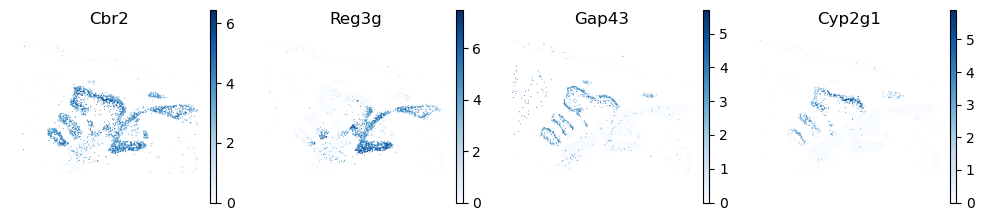

In [28]:
marker_gene4 = ['Cbr2','Reg3g','Gap43','Cyp2g1']
sc.settings.figdir = '/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4'
sc.pl.spatial(adata_olfactory, color=marker_gene4, spot_size=20,
              cmap='Blues',size=1,frameon=False, show=False,ncols=4)
plt.gcf().set_size_inches(12, 2.5)  # Set the figure size as width=10, height=8 inches
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4e_H4_2_olfactory_4genes.png'),dpi=300)
plt.show()

In [14]:
adata_olfactory.var['means_olfactory'] = np.mean(adata_olfactory.X, axis=0)

/tmp/ipykernel_932772/3201788258.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata_olfactory.var['means_olfactory'] = np.mean(adata_olfactory.X, axis=0)


In [15]:
adata_olfactory.var['olfactory_enrich'] = adata_olfactory.var['means_olfactory'] / adata_olfactory.var['means']

In [53]:
adata_olfactory.var.sort_values(by='olfactory_enrich',ascending=False).head(30)

n_cells  n_counts  log10_counts  log10_cells     mt  \
Sec14l3     2714    4173.0      3.620448     3.464340  False   
Ccdc153     1684    2279.0      3.357744     3.272538  False   
Fstl5       2212    4699.0      3.672005     3.536306  False   
Dynlrb2     1822    2371.0      3.374932     3.295787  False   
Cyp2f2      3681    5962.0      3.775392     3.620448  False   
Lypd2       2566    3394.0      3.530712     3.464936  False   
Bpifb9a     2692   10526.0      4.022264     3.515079  False   
Aldh1a1     3601    5215.0      3.717254     3.617000  False   
Krt19       3517    5149.0      3.711723     3.596597  False   
Gng13       1494    1969.0      3.294246     3.245019  False   
Wfdc2       2392    2959.0      3.471145     3.418467  False   
Bpifb5      3610   15013.0      4.176467     3.676328  False   
Ccdc181     2389    2883.0      3.459845     3.411283  False   
Krt18       4173    5315.0      3.725503     3.669131  False   
Cyp2g1      1950    4161.0      3.619198     3.345374  False   
Dnah9       2546    5342.0      3.727704     3.652053  False   
Med12l      2537    4244.0      3.627775     3.574610  False   
Cbr2       12844   25529.0      4.407034     4.161937  False   
Olfm5       2074    6081.0      3.783975     3.379124  False   
Agr2        2124    2640.0      3.421604     3.357363  False   
Spint2      5200    6252.0      3.796019     3.761853  False   
Cntn4       3474    7563.0      3.878694     3.769303  False   
Cdh1        3266    7509.0      3.875582     3.837273  False   
Cds1        2593    3084.0      3.489114     3.451786  False   
Atf5        5219    6639.0      3.822103     3.762303  False   
Pifo        1540    2368.0      3.374382     3.356790  False   
Agbl4       2669    4841.0      3.684935     3.649432  False   
Lhx2        3541    4527.0      3.655811     3.586925  False   
Bpifb9b     5102   36941.0      4.567509     3.856910  False   
Dcxr        1725    2059.0      3.313656     3.291813  False   

         n_cells_by_counts  mean_counts  pct_dropout_by_counts  total_counts  \
Sec14l3               2714     0.008197              99.438946        3965.0   
Ccdc153               1684     0.004304              99.651873        2082.0   
Fstl5                 2212     0.007157              99.542722        3462.0   
Dynlrb2               1822     0.004577              99.623345        2214.0   
Cyp2f2                3681     0.011281              99.239041        5457.0   
Lypd2                 2566     0.006276              99.469541        3036.0   
Bpifb9a               2692     0.020515              99.443494        9924.0   
Aldh1a1               3601     0.009640              99.255580        4663.0   
Krt19                 3517     0.009722              99.272945        4703.0   
Gng13                 1494     0.003514              99.691151        1700.0   
Wfdc2                 2392     0.005623              99.505511        2720.0   
Bpifb5                3610     0.028611              99.253719       13840.0   
Ccdc181               2389     0.005567              99.506131        2693.0   
Krt18                 4173     0.009939              99.137332        4808.0   
Cyp2g1                1950     0.008042              99.596884        3890.0   
Dnah9                 2546     0.006987              99.473676        3380.0   
Med12l                2537     0.006233              99.475536        3015.0   
Cbr2                 12844     0.049217              97.344811       23808.0   
Olfm5                 2074     0.011899              99.571250        5756.0   
Agr2                  2124     0.005137              99.560914        2485.0   
Spint2                5200     0.011705              98.925025        5662.0   
Cntn4                 3474     0.010615              99.281834        5135.0   
Cdh1                  3266     0.007934              99.324833        3838.0   
Cds1                  2593     0.005875              99.463959        2842.0   
Atf5                  52

## FigS11_b

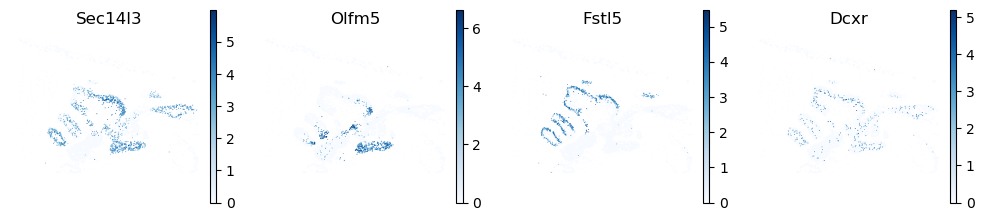

In [29]:
## FigS4f
marker_gene4 = ['Sec14l3','Olfm5','Fstl5','Dcxr']
sc.settings.figdir = '/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4'
sc.pl.spatial(adata_olfactory, color=marker_gene4, spot_size=20,
              cmap='Blues',size=1,frameon=False, show=False,ncols=4)
plt.gcf().set_size_inches(12, 2.5)  # Set the figure size as width=10, height=8 inches
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4f_H4_2_olfactory_4moregenes.png'),dpi=300)
plt.show()

# Epithelial cells

In [15]:
adata_epithelial = adata[(adata.obs.spot_class == 'singlet') & (adata.obs.first_type == 'Epithelial_cells')].copy()

## FigS9_g

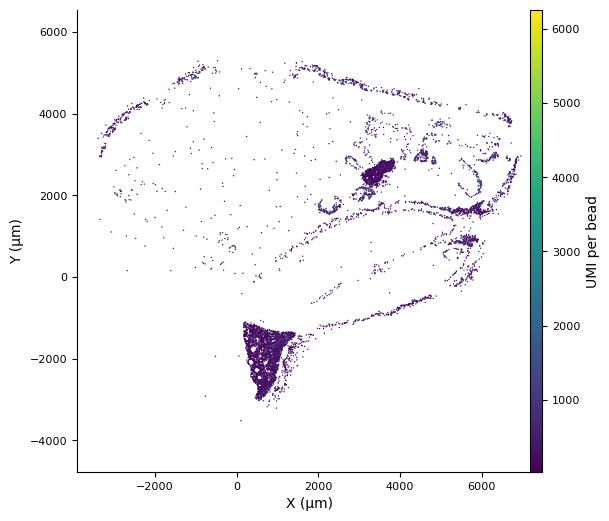

In [17]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()
im = ax.scatter(x=adata_epithelial.obs.x, y=adata_epithelial.obs.y, c=adata_epithelial.obs.n_counts, alpha=1, s=1, edgecolor='none',cmap='viridis')
plt.axis('equal')
plt.xlabel('X (µm)', fontsize=10)
plt.ylabel('Y (µm)', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
cax = fig.add_axes([ax.get_position().x1-0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, pad=0.05, shrink=0.6)
cbar.ax.tick_params(labelsize=8, which='major') 
cbar.set_label('UMI per bead', fontsize=10)
plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4f_H4_2_umi_per_bead_spatial_epithelial.png'),dpi=300)
# plt.close()
plt.show()

In [ ]:
epi_de = pd.read_csv('/mnt/thechenlab/Chenlei/spotmapping/fiducial/data/H4_2/olfactory_de/de_summary/sig_Epithelial_cells.csv')
epi_de.columns = ['gene'] + list(epi_de.columns[1:])

In [18]:
epi_de_gene20 = epi_de.gene[:20].values
sq.gr.spatial_neighbors(adata_epithelial)
sq.gr.spatial_autocorr(
    adata_epithelial,
    mode="moran",
    genes=epi_de_gene20,
    n_perms=100,
    n_jobs=10,
    use_raw=True
)

moranI_gene20 = [adata_epithelial.uns["moranI"].loc[gene,'I'] for gene in epi_de_gene20]

## Fig2_l

/home/thechenlab/miniconda3/envs/slidelock/lib/python3.11/site-packages/seaborn/categorical.py:510: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_1346531/946030139.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=50)
/home/thechenlab/miniconda3/envs/slidelock/lib/python3.11/site-packages/seaborn/categorical.py:510: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wit

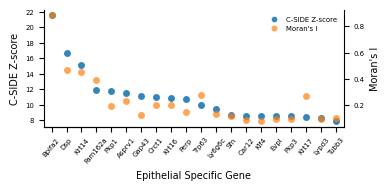

In [75]:
from matplotlib.lines import Line2D
fig, ax1 = plt.subplots(figsize=(4, 2))
sns.stripplot(data=epi_de.iloc[:20,], x="gene", y="Z_score", ax=ax1, c=sns.color_palette("tab10")[0], alpha=0.9)
ax1.set_ylabel('C-SIDE Z-score', fontsize=7)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=50)
ax1.set_xlabel('Epithelial Specific Gene', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.twinx()
sns.stripplot(x=epi_de.iloc[:20,].gene, y=moranI_gene20, ax=ax2, c=sns.color_palette("tab10")[1], alpha=0.7)
ax2.set_ylabel("Moran's I", fontsize=7)
ax2.tick_params(axis='both', which='major', labelsize=5)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Create custom Line2D objects as legend keys to resemble dots
legend_dot1 = Line2D([0], [0], marker='o', color='w', label='C-SIDE Z-score',
                     markerfacecolor=sns.color_palette("tab10")[0], markersize=5, alpha=0.9)
legend_dot2 = Line2D([0], [0], marker='o', color='w', label="Moran's I",
                     markerfacecolor=sns.color_palette("tab10")[1], markersize=5, alpha=0.7)

# Add the legend to the plot with dot markers
plt.legend(handles=[legend_dot1, legend_dot2], loc='upper right', fontsize=5, frameon=False)  # frameon=False removes the box around the legend

# Adjust layout and show plot
fig.tight_layout()
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4','Fig4j_H4_2_epithelial_de.svg'),dpi=300)
plt.show()

## Fig2_m

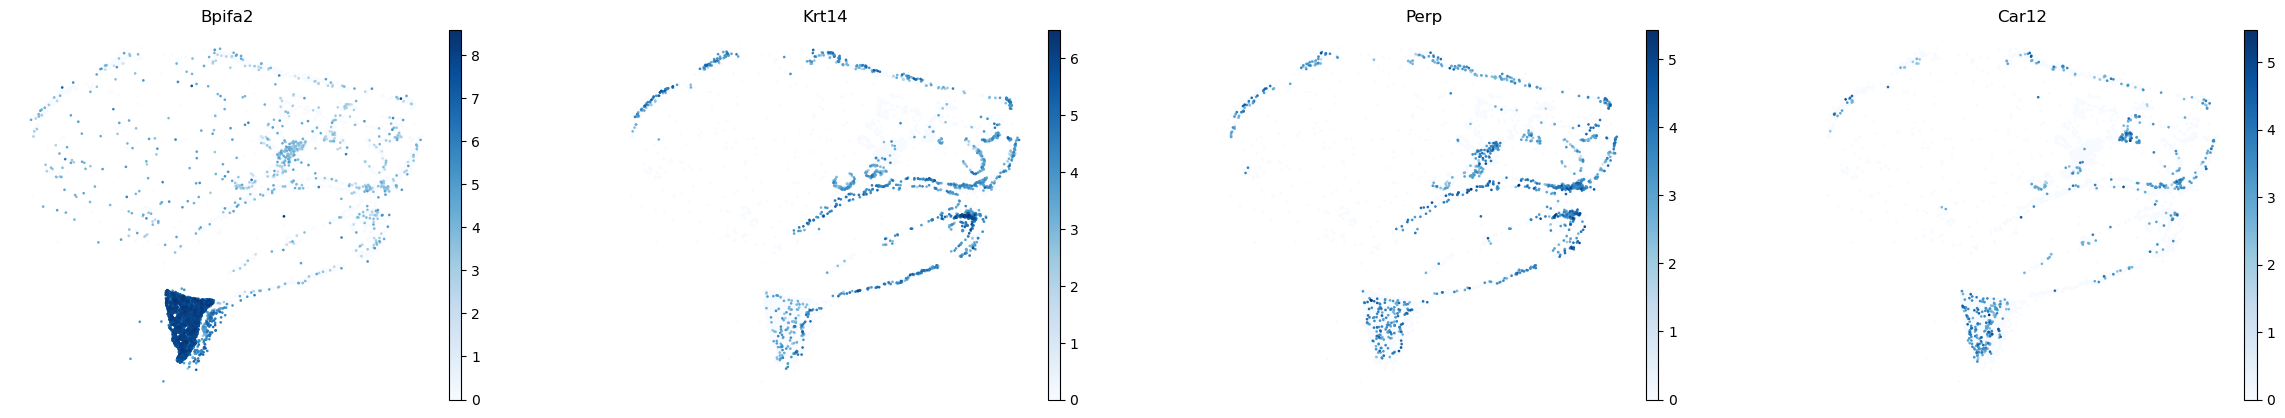

<Figure size 1200x300 with 0 Axes>

In [107]:
epi_de_gene4 = ['Bpifa2','Krt14','Perp','Car12']
sc.settings.figdir = '/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/Fig4'
sc.pl.spatial(adata_epithelial, color=epi_de_gene4, spot_size=70,cmap='Blues',size=1,frameon=False, save='Fig4k_epithelial_de_gene4.svg')
plt.gcf().set_size_inches(12, 3)  # Set the figure size as width=10, height=8 inches
plt.show()

# Muslce cells

In [30]:
adata_muscle = adata[(adata.obs.spot_class == 'singlet') & (adata.obs.first_type == 'Muscle_cells')].copy()

In [ ]:
mus_de = pd.read_csv('/mnt/thechenlab/Chenlei/spotmapping/fiducial/data/H4_2/type12_29_de/de_summary/sig_Muscle_cells.csv')
mus_de.columns = ['gene'] + list(mus_de.columns[1:])

## FigS12_a

In [7]:
mus_de_gene100 = mus_de.gene[:100].values
sq.gr.spatial_neighbors(adata_muscle)
sq.gr.spatial_autocorr(
    adata_muscle,
    mode="moran",
    genes=mus_de_gene100,
    n_perms=100,
    n_jobs=10,
    use_raw=True
)

moranI_gene100 = [adata_muscle.uns["moranI"].loc[gene,'I'] for gene in mus_de_gene100]

  0%|          | 0/100 [00:00<?, ?/s]

/home/thechenlab/miniconda3/envs/slidelock/lib/python3.11/site-packages/seaborn/categorical.py:510: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  points = ax.scatter(sub_data["x"], sub_data["y"], color=color, **plot_kws)
/tmp/ipykernel_1478560/2677593248.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=50)
/home/thechenlab/miniconda3/envs/slidelock/lib/python3.11/site-packages/seaborn/categorical.py:510: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches wi

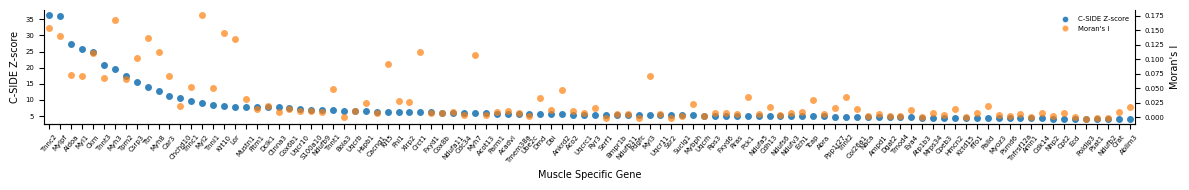

In [10]:
from matplotlib.lines import Line2D
fig, ax1 = plt.subplots(figsize=(12, 2))
sns.stripplot(data=mus_de.iloc[:100,], x="gene", y="Z_score", ax=ax1, c=sns.color_palette("tab10")[0], alpha=0.9)
ax1.set_ylabel('C-SIDE Z-score', fontsize=7)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=50)
ax1.set_xlabel('Muscle Specific Gene', fontsize=7)
ax1.tick_params(axis='both', which='major', labelsize=5)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2 = plt.twinx()
sns.stripplot(x=mus_de.iloc[:100,].gene, y=moranI_gene100, ax=ax2, c=sns.color_palette("tab10")[1], alpha=0.7)
ax2.set_ylabel("Moran's I", fontsize=7)
ax2.tick_params(axis='both', which='major', labelsize=5)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

# Create custom Line2D objects as legend keys to resemble dots
legend_dot1 = Line2D([0], [0], marker='o', color='w', label='C-SIDE Z-score',
                     markerfacecolor=sns.color_palette("tab10")[0], markersize=5, alpha=0.9)
legend_dot2 = Line2D([0], [0], marker='o', color='w', label="Moran's I",
                     markerfacecolor=sns.color_palette("tab10")[1], markersize=5, alpha=0.7)

# Add the legend to the plot with dot markers
plt.legend(handles=[legend_dot1, legend_dot2], loc='upper right', fontsize=5, frameon=False)  # frameon=False removes the box around the legend

# Adjust layout and show plot
fig.tight_layout()
# plt.savefig(os.path.join('/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4','FigS4j_H4_2_muscle_de.svg'),dpi=300)
plt.show()

## FigS12_b

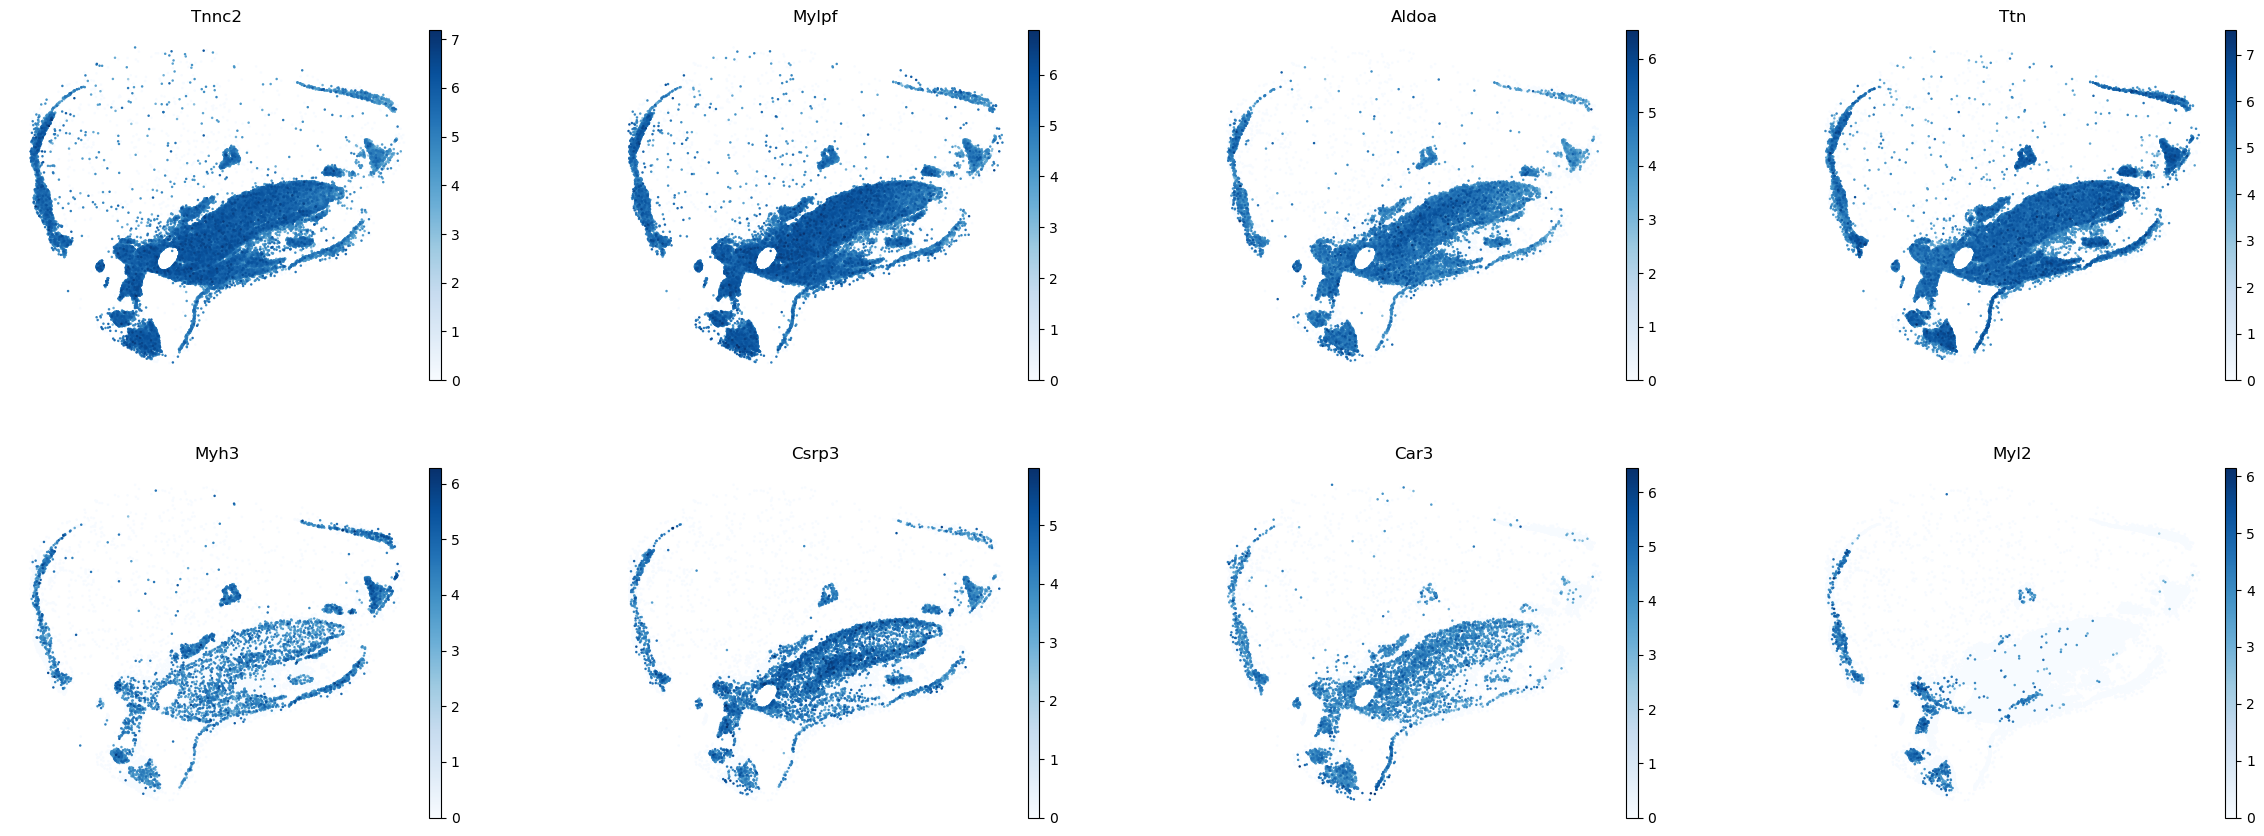

<Figure size 1200x300 with 0 Axes>

In [32]:
## FigS4i
mus_de_gene8 = ['Tnnc2','Mylpf','Aldoa','Ttn','Myh3','Csrp3','Car3','Myl2']
sc.settings.figdir = '/mnt/thechenlab/Chenlei/spotmapping/fiducial/Figures/FigS4'
sc.pl.spatial(adata_muscle, color=mus_de_gene8, spot_size=70,cmap='Blues',size=1,frameon=False, save='FigS4i_muscle_de_gene8.png')
plt.gcf().set_size_inches(12, 3)  # Set the figure size as width=10, height=8 inches
plt.show()